# Большое домашнее задание

Готово 2 из 3.

* Реализовать  вариант МД для экранированного кулоновского потенциала, использующий грубую пространственную клетку с клетками. Продемонстрировать его работу для $10^2 \dots 10^3$ частиц  и сравнить эффективность с примитивным вариантом $O(N^2)$. Предлагаемая геометрия -- 5x5 клеток.


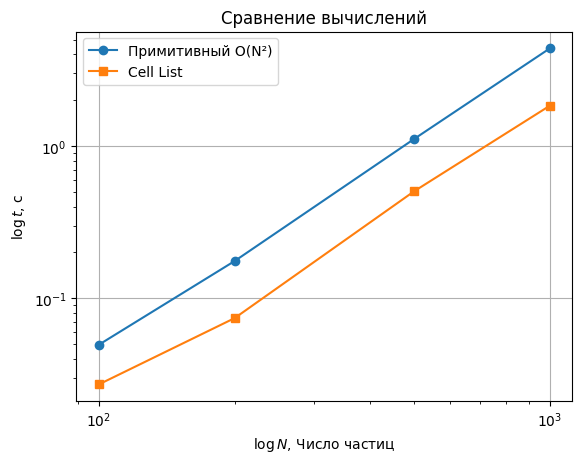

In [14]:
import numpy as np
import time
import matplotlib.pyplot as plt


class ParticleSystem:
    def __init__(self, N, L=10.0, kappa=0.5, rc=3.0):
        self.N = N
        self.L = L
        self.kappa = kappa  # Параметр экранирования
        self.rc = rc  # Радиус обрезания
        self.charges = np.random.choice([-1, 1], N)
        self.positions = np.random.rand(N, 2) * L
        self.velocities = np.zeros((N, 2))
        self.forces = np.zeros((N, 2))

        # Параметры клеточной структуры
        self.cell_size = L / 5
        self.ncells = 5
        self.cells = [[[] for _ in range(self.ncells)] for _ in range(self.ncells)]

    def update_cells(self):
        """Обновление клеточной структуры"""
        self.cells = [[[] for _ in range(self.ncells)] for _ in range(self.ncells)]
        for i in range(self.N):
            ix = int(self.positions[i, 0] / self.cell_size) % self.ncells
            iy = int(self.positions[i, 1] / self.cell_size) % self.ncells
            self.cells[ix][iy].append(i)

    def yukawa_force(self, i, j, r):  # Добавляем i и j как параметры
        """Сила для потенциала Юкавы между частицами i и j"""
        r_norm = np.linalg.norm(r)
        if r_norm == 0 or r_norm > self.rc:
            return np.zeros(2)
        # Используем заряды конкретных частиц
        return (
            self.charges[i]
            * self.charges[j]
            * np.exp(-self.kappa * r_norm)
            * (1 + self.kappa * r_norm)
            / r_norm**3
        ) * r

    def compute_forces_naive(self):
        """Наивный метод O(N²)"""
        self.forces.fill(0)
        for i in range(self.N):
            for j in range(i + 1, self.N):
                r = self.positions[j] - self.positions[i]
                r -= np.round(r / self.L) * self.L  # PBC
                f = self.yukawa_force(i, j, r)  # Передаем i и j
                self.forces[i] -= f
                self.forces[j] += f

    def compute_forces_cells(self):
        """Клеточный метод"""
        self.forces.fill(0)
        for ix in range(self.ncells):
            for iy in range(self.ncells):
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        jx = (ix + dx) % self.ncells
                        jy = (iy + dy) % self.ncells
                        for i in self.cells[ix][iy]:
                            for j in self.cells[jx][jy]:
                                if j <= i:
                                    continue
                                r = self.positions[j] - self.positions[i]
                                r -= np.round(r / self.L) * self.L
                                if np.linalg.norm(r) > self.rc:
                                    continue
                                f = self.yukawa_force(i, j, r)  # Передаем i и j
                                self.forces[i] -= f
                                self.forces[j] += f

    def integrate(self, dt=0.001):
        """Интеграция методом Верле"""
        self.positions += self.velocities * dt + 0.5 * self.forces * dt**2
        self.velocities += 0.5 * self.forces * dt


# Сравнение производительности
Ns = [100, 200, 500, 1000]
times_naive = []
times_cells = []

for N in Ns:
    ps = ParticleSystem(N)

    # Тест наивного метода
    start = time.time()
    ps.compute_forces_naive()
    times_naive.append(time.time() - start)

    # Тест клеточного метода
    ps.update_cells()
    start = time.time()
    ps.compute_forces_cells()
    times_cells.append(time.time() - start)

# Визуализация результатов
plt.plot(Ns, times_naive, "o-", label="Примитивный O(N²)")
plt.plot(Ns, times_cells, "s-", label="Cell List")
plt.xlabel(r"$\log{N}$, Число частиц")
plt.ylabel(r"$\log{t}$, с")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.grid(True)
plt.title("Сравнение вычислений")
plt.show()

* Освоить работу существующего пакета, реализующего МД для Python (например OpenMM). Реализовать с его помощью моделирование движения $10^2 \dots 10^4$ заряженных частиц. Найти параметры для возникновения плазменных колебаний (колебаний объёмной плотности заряда).

> Работает очень долго!

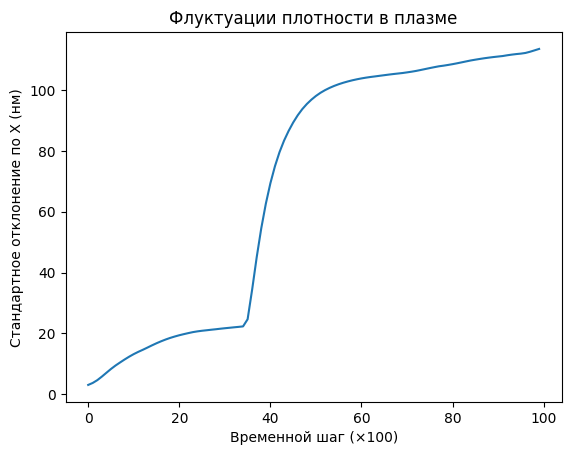

In [15]:
import openmm
from openmm import unit
from openmm.app import *
import numpy as np
import matplotlib.pyplot as plt

# Параметры системы
N = 1000  # Число частиц
charge_magnitude = 1.0 * unit.elementary_charge
mass = 40.0 * unit.amu
temperature = 300 * unit.kelvin
box_size = 10.0 * unit.nanometers  # Размер периодической ячейки

# Создание системы с периодическими граничными условиями
# Вселенная работает как в игре "Змейка": частица при переходе границы появляется с противоположной
system = openmm.System()
system.setDefaultPeriodicBoxVectors(
    [box_size, 0, 0], [0, box_size, 0], [0, 0, box_size]
)

# Добавление частиц. Позже добавим силы, создаваемые здесь отдельно, и объединим их с частицами
for i in range(N):
    system.addParticle(mass)

# Настройка кулоновских взаимодействий
force = openmm.NonbondedForce()
force.setNonbondedMethod(openmm.NonbondedForce.PME)

# Добавление зарядов (+1 и -1 попеременно)
for i in range(N):
    charge = charge_magnitude if i % 2 == 0 else -charge_magnitude
    force.addParticle(
        charge, 0.0, 0.0
    )  # Нули обозначают: только кулоновское взаимодействие

system.addForce(force)

# Инициализация симуляции, размещаем частицы случайно в пределах куба
topology = Topology()
positions = (
    np.random.rand(N, 3) * box_size.value_in_unit(unit.nanometers) * unit.nanometers
)

integrator = openmm.LangevinIntegrator(
    temperature, 1.0 / unit.picoseconds, 0.002 * unit.picoseconds
)

platform = openmm.Platform.getPlatformByName("CPU")
simulation = Simulation(topology, system, integrator, platform)
simulation.context.setPositions(positions)
simulation.context.setVelocitiesToTemperature(temperature)

# Сбор данных о флуктуациях
std_dev_history = []
for step in range(100):
    simulation.step(100)  # 100 шагов между записями
    state = simulation.context.getState(getPositions=True)
    positions = state.getPositions()
    pos_nm = np.array([p.value_in_unit(unit.nanometers) for p in positions])
    std_dev_history.append(np.std(pos_nm[:, 0]))  # Только по оси X

# Визуализация
plt.plot(std_dev_history)
plt.xlabel("Временной шаг (×100)")
plt.ylabel("Стандартное отклонение по X (нм)")
plt.title("Флуктуации плотности в плазме")
plt.show()